In [25]:
# Explanation of prediction output when activation is sigmoid:
# https://forum.freecodecamp.org/t/model-predict-output/470349

import tensorflow as tf
import tensorflow_datasets as tfds
import logging, os
import pandas as pd
import time
from tensorflow.keras.models import load_model
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

BASE_PATH = "../../../../../local_data/practice/tfds/"
DATA_PATH = "../../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"cats_vs_dogs/"
os.system("mkdir -p " + OUTPUT_PATH)

0

In [26]:
import tensorflow_datasets as tfds

DATA_PATH = "../../../../../local_data/datasets/animals/"
# Initialize the ImageFolder dataset
builder = tfds.ImageFolder(DATA_PATH)

# Print dataset information
metadata=builder.info
# print(builder.info)  # This will show the number of examples, labels, etc.

# Create the dataset
test_dataset = builder.as_dataset(
    split='test',
    shuffle_files=False,
    as_supervised=True
)

print(f"Number of test samples: {test_dataset.cardinality()}")

Number of test samples: 9


In [27]:
# Preprocess the data
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0
    return image, label

# train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

batch_size = 64
# train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(buffer_size=10)

In [28]:
# Load model
# filename = "valacc_0.641_epochs_10_date_20250719-150250.h5"
# filename = "valacc_0.711_epochs_10_date_20250719-150859.h5"
filename = "valacc_0.779_epochs_20_date_20250726-163523.h5"

fullpath = f"{OUTPUT_PATH}{filename}"
model = load_model(fullpath)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 512)               1

In [29]:
# Make predictions
predictions = model.predict(test_dataset)
allpreds=predictions.flatten()
allpnorms = np.where(allpreds > 0.5, 1, 0)

alllabels=np.empty(0)
for images, labels in test_dataset:
    alllabels = np.append(alllabels, labels.numpy().flatten())

score = metrics.accuracy_score(alllabels, allpnorms)
print("Validation accuracy score: {}".format(score))

collabels = pd.DataFrame(alllabels, columns=["l"])
colpreds = pd.DataFrame( allpreds, columns=["pred"])
pnorm = pd.DataFrame( allpnorms, columns=["pnorm"])
diff = collabels["l"] - pnorm["pnorm"]

compare = pd.concat([collabels, colpreds,pnorm,diff], axis=1)
compare.columns = ["l", "pred", "pnorm","diff"]
print(compare)

compare.to_csv(OUTPUT_PATH + "pred_test_load.csv", index=False)    

1/1 [==============================] - 0s 115ms/step
Validation accuracy score: 0.7777777777777778
     l          pred  pnorm  diff
0  1.0  1.000000e+00      1   0.0
1  0.0  1.966333e-01      0   0.0
2  1.0  9.999996e-01      1   0.0
3  1.0  9.998834e-01      1   0.0
4  1.0  9.999385e-01      1   0.0
5  0.0  9.997826e-01      1  -1.0
6  0.0  6.999172e-10      0   0.0
7  0.0  9.999959e-01      1  -1.0
8  1.0  9.999021e-01      1   0.0


,image,label,predictions,pred norm,correct
0,,1 (dog),1.000000,1,True
1,,0 (cat),0.196633,0,True
2,,1 (dog),1.000000,1,True
3,,1 (dog),0.999883,1,True
4,,1 (dog),0.999938,1,True
5,,0 (cat),0.999783,1,False
6,,0 (cat),0.000000,0,True
7,,0 (cat),0.999996,1,False
8,,1 (dog),0.999902,1,True

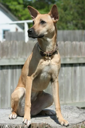
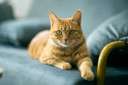
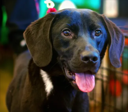
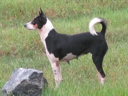
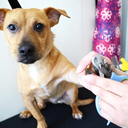
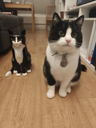
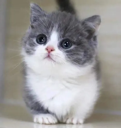
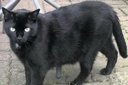
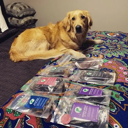

In [30]:
# # Reload the dataset (need without pre-processing)
test_dataset = builder.as_dataset(
    split='test',
    shuffle_files=False,
    as_supervised=True
)

number_of_images=9
allcorrect = (allpnorms == alllabels)

new_df=tfds.as_dataframe(test_dataset.take(number_of_images), metadata)
new_df['predictions'] = allpreds[0:number_of_images]
new_df['pred norm'] = allpnorms[0:number_of_images]
new_df['correct'] = allcorrect[0:number_of_images]
new_df